In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, SpatialDropout1D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn import preprocessing, model_selection


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import numpy as np
def load_data(folder):
  x_data = []
  y_data = []
  num_of_subjects = 109

  # used to make sure length for all channels is uniform
  proper_length = 401
  # TODO, change path to pickle folder

  x, y = [], []

  for i in range(1, 110):
    with open(f'{folder}/S{i}.pickle', 'rb') as file:
      data = pickle.load(file)

    grab_x, grab_y = data[0], data[1]
    # print(grab_x.shape, grab_y.shape)
    if grab_x.shape[2] == 401:
      # x.append(grab_x)
      # y.append(grab_y)
      temp_x, temp_y = [], []
      for j in range(grab_y.shape[0]):
        max_index = np.argmax(grab_y[j])

        # if max_index != 4:
        temp_x.append(grab_x[j])
        if max_index == 0:
          temp_y.append(0)
        else:
          temp_y.append(1)

      temp_x = np.array(temp_x)
      temp_y = np.array(temp_y)
      # print(temp_x.shape, temp_y.shape)



    x.append(temp_x)
    y.append(temp_y)
    print(f"pickle file {i} loaded")

  x= np.concatenate(x, axis=0)
  y= np.concatenate(y, axis=0)
  return x, y

In [ ]:
x_1, y_1=load_data( 'drive/MyDrive/Data Processing /ERP_pickle_files/delta_wave_pickle_files/')
x_2, y_2 = load_data('drive/MyDrive/Data Processing /ERP_pickle_files/new_pickle_files/')

pickle file 1 loaded
pickle file 2 loaded
pickle file 3 loaded
pickle file 4 loaded
pickle file 5 loaded
pickle file 6 loaded
pickle file 7 loaded
pickle file 8 loaded
pickle file 9 loaded
pickle file 10 loaded
pickle file 11 loaded
pickle file 12 loaded
pickle file 13 loaded
pickle file 14 loaded
pickle file 15 loaded
pickle file 16 loaded
pickle file 17 loaded
pickle file 18 loaded
pickle file 19 loaded
pickle file 20 loaded
pickle file 21 loaded
pickle file 22 loaded
pickle file 23 loaded
pickle file 24 loaded
pickle file 25 loaded
pickle file 26 loaded
pickle file 27 loaded
pickle file 28 loaded
pickle file 29 loaded
pickle file 30 loaded
pickle file 31 loaded
pickle file 32 loaded
pickle file 33 loaded
pickle file 34 loaded
pickle file 35 loaded
pickle file 36 loaded
pickle file 37 loaded
pickle file 38 loaded
pickle file 39 loaded
pickle file 40 loaded
pickle file 41 loaded
pickle file 42 loaded
pickle file 43 loaded
pickle file 44 loaded
pickle file 45 loaded
pickle file 46 load

In [ ]:
x =np.append(x_1,x_2,1)
print(x.shape,)
x = np.reshape(x, (-1, 401, 6))
print(x.shape,)
y=y_1

(3924, 6, 401)
(3924, 401, 6)


[1308, 2616]


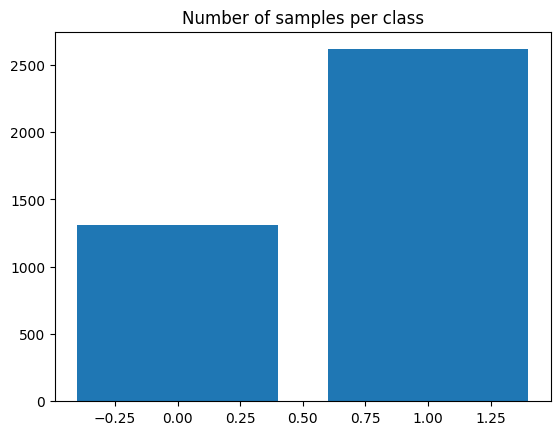

In [ ]:
import matplotlib.pyplot as plt
distribution = [0, 0]
NUM_CLASSES = 2
for i in range(y.shape[0]):
  distribution[y[i]] += 1
print(distribution)
plt.bar(range(NUM_CLASSES), distribution)
plt.title("Number of samples per class")
plt.show()

In [ ]:
neg = distribution[0]
pos = distribution[1]
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.50
Weight for class 1: 0.75


In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x, y, test_size=0.10, random_state=42, shuffle=True
)

BATCH_SIZE =16
SHUFFLE_BUFFER_SIZE = 2 * BATCH_SIZE # larger buffer size allows better shuffling of data

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Activation, GlobalAveragePooling1D

def create_model():

    dropout_rate = 0.2

    input_layer = keras.Input(shape=(401, 6))

    x = Conv1D(filters=32, kernel_size=3, strides=2, activation='relu', kernel_initializer=HeNormal(), padding="same")(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Conv1D(filters=64, kernel_size=3, strides=2, activation='relu', kernel_initializer=HeNormal(), padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Conv1D(filters=128, kernel_size=3, strides=2, activation='relu', kernel_initializer=HeNormal(), padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Flatten()(x)

    x = Dense(1024, activation="relu", kernel_initializer=HeNormal())(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(256, activation="relu", kernel_initializer=HeNormal())(x)
    x = Dropout(dropout_rate)(x)

    output_layer = Dense(1, kernel_initializer=HeNormal(), activation="sigmoid")(x)

    return keras.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model = create_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 401, 6)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 201, 32)           608       
                                                                 
 batch_normalization_3 (Bat  (None, 201, 32)           128       
 chNormalization)                                                
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 100, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 50, 64)            6208      
                                                                 
 batch_normalization_4 (Bat  (None, 50, 64)            256 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-7)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

# Assuming train_dataset and test_dataset are defined and ready for training

# Fit the model with callbacks
epochs = 500
model_history = model.fit(x=x_train, y=y_train,
    epochs=epochs,
    validation_data=test_dataset,
    class_weight=class_weight
)

Epoch 1/500
111/111 [==============================] - 7s 38ms/step - loss: 0.7166 - binary_accuracy: 0.4662 - auc: 0.5174 - precision: 0.6982 - recall: 0.3610 - val_loss: 0.6946 - val_binary_accuracy: 0.3766 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
111/111 [==============================] - 6s 54ms/step - loss: 0.6887 - binary_accuracy: 0.5200 - auc: 0.5871 - precision: 0.7439 - recall: 0.4348 - val_loss: 0.6960 - val_binary_accuracy: 0.3766 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/500
111/111 [==============================] - 4s 37ms/step - loss: 0.6799 - binary_accuracy: 0.5469 - auc: 0.6141 - precision: 0.7631 - recall: 0.4715 - val_loss: 0.6979 - val_binary_accuracy: 0.3766 - val_auc: 0.5027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/500
111/111 [==============================] - 4s 34ms/step - loss: 0.6767 - binary_accuracy: 0.5585 - auc: 0.6266 - precision: 0.7633 - recall: 0.4964 

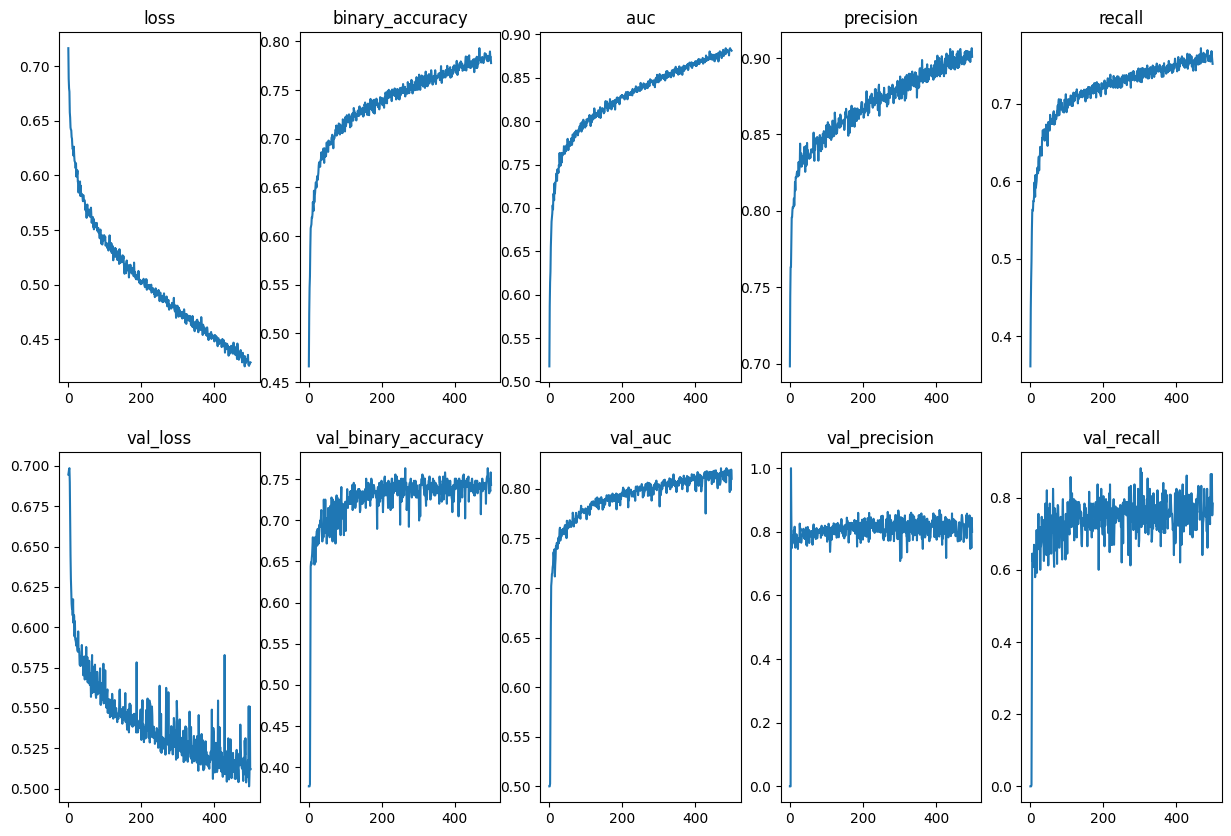

In [ ]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()
plot_history_metrics(model_history)

In [ ]:
results_train = model.evaluate(train_dataset, verbose = 0)
print(f"Binary Crossentropy Loss on Training Data: {results_train[0]}")
print(f"AUC on Training Data: {results_train[2]}")
print(f"Classification Accuracy on Training Data: {round(results_train[1] * 100)}%")
print(f"Precision on Training Data: {round(results_train[3] * 100)}%")
print(f"Recall on Training Data: {round(results_train[4] * 100)}%")

print()

results_test = model.evaluate(test_dataset, verbose = 0)
print(f"Binary Crossentropy Loss on Test Data: {results_test[0]}")
print(f"AUC on Test Data: {results_test[2]}")
print(f"Classification Accuracy on Test Data: {round(results_test[1] * 100)}%")
print(f"Precision on Test Data: {round(results_test[3] * 100)}%")
print(f"Recall on Test Data: {round(results_test[4] * 100)}%")

Binary Crossentropy Loss on Training Data: 0.4048079252243042
AUC on Training Data: 0.884029746055603
Classification Accuracy on Training Data: 80%
Precision on Training Data: 88%
Recall on Training Data: 81%

Binary Crossentropy Loss on Test Data: 0.5120210647583008
AUC on Test Data: 0.8099972605705261
Classification Accuracy on Test Data: 74%
Precision on Test Data: 80%
Recall on Test Data: 78%


In [ ]:
model.save("model_with_delta.keras")